# Tune Multithreading Support for XGBoost

The XGBoost library for gradient boosting is designed for efficient multi-core parallel processing.

This allows it to efficiently use all of the CPU cores in your system when training.

Here you will discover the parallel processing capabilities of the XGBoost.

By the end you will know:

- How to confirm that XGBoost multi-threading support is working on your system?
- How to evaluate the effect of increasing the number of threads on XGBoost?
- How to get the most out of multithreaded XGBoost when using cross validation and grid search?

## Problem Description: Otto Dataset

We will use the Otto Group Product Classification Challenge [dataset](https://www.kaggle.com/c/otto-group-product-classification-challenge).

This dataset describes the 93 obfuscated details of more than 61,000 products grouped into 10 product categories (e.g. fashion, electronics, etc.). Input attributes are counts of different events of some kind.

The goal is to make predictions for new products as an array of probabilities for each of the 10 categories and models are evaluated using multiclass logarithmic loss (also called cross entropy).

This dataset is a good challenge for XGBoost because of the nontrivial number of examples and the difficulty of the problem and the fact that little data preparation is required (other than encoding the string class variables as integers).

## Impact of the Number of Threads

XGBoost is implemented in C++ to explicitly make use of the OpenMP API for parallel processing.

The parallelism in gradient boosting can be implemented in the construction of individual trees, rather than in creating trees in parallel like random forest. This is because in boosting, trees are added to the model sequentially. The speed of XGBoost is both in adding parallelism in the construction of individual trees, and in the efficient preparation of the input data to aid in the speed up in the construction of trees.

Depending on your platform, you may need to compile XGBoost specifically to support multithreading. See the XGBoost installation [instructions](https://github.com/dmlc/xgboost/blob/master/doc/build.md) for more details.

The **XGBClassifier** and **XGBRegressor** wrapper classes for XGBoost for use in scikit-learn provide the **nthread** parameter to specify the number of threads that XGBoost can use during training.

By default this parameter is set to -1 to make use of all of the cores in your system.

<pre>
model = XGBClassifier(nthread=-1)
</pre>

Generally, you should get multithreading support for your XGBoost installation without any extra work.

Depending on your Python environment (e.g. Python 3) you may need to explicitly enable multithreading support for XGBoost. The XGBoost library provides an [example](https://github.com/dmlc/xgboost/blob/master/demo/guide-python/sklearn_parallel.py) if you need help.

You can confirm that XGBoost multi-threading support is working by building a number of different XGBoost models, specifying the number of threads and timing how long it takes to build each model. The trend will both show you that multi-threading support is enabled and give you an indication of the effect it has when building models.

For example, if your system has 4 cores, you can train 8 different models and time how long in seconds it takes to create each, then compare the times.

<pre>
# evaluate the effect of the number of threads
results = []
num_threads = [1, 2, 3, 4]
for n in num_threads:
	start = time.time()
	model = XGBClassifier(nthread=n)
	model.fit(X_train, y_train)
	elapsed = time.time() - start
	print(n, elapsed)
	results.append(elapsed)
</pre>

We can use this approach on the Otto dataset. The full example is provided below for completeness.

You can change the **num_threads** array to meet the number of cores on your system.

(1, 129.04913306236267)
(2, 64.2027359008789)
(3, 43.49239802360535)
(4, 32.77219486236572)


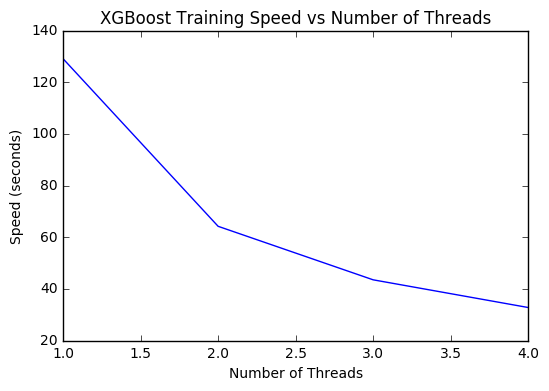

In [1]:
# Otto, tune number of threads
from pandas import read_csv
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import time
from matplotlib import pyplot

# load data
data = read_csv('train.csv')
dataset = data.values

# split data into X and y
X = dataset[:,0:94]
y = dataset[:,94]

# encode string class values as integers
label_encoded_y = LabelEncoder().fit_transform(y)

# evaluate the effect of the number of threads
results = []
num_threads = [1, 2, 3, 4]
for n in num_threads:
    start = time.time()
    model = XGBClassifier(nthread=n)
    model.fit(X, label_encoded_y)
    elapsed = time.time() - start
    print(n, elapsed)
    results.append(elapsed)
    
# plot results
pyplot.plot(num_threads, results)
pyplot.ylabel('Speed (seconds)')
pyplot.xlabel('Number of Threads')
pyplot.title('XGBoost Training Speed vs Number of Threads')
pyplot.show()

We can see a nice trend in the decrease in execution time as the number of threads is increased.

If you do not see an improvement in running time for each new thread, you may want to investigate how to enable multithreading support in XGBoost as part of your install or at runtime.

We can run the same code on a machine with a lot more cores. The large Amazon Web Services EC2 instance is reported to have 32 cores. We can adapt the above code to time how long it takes to train the model with 1 to 32 cores.The results are plotted below.

<img src="ec2-graph.png" alt="ec2-graph" align="left" style="width:600px;"/>


It is interesting to note that we do not see much improvement beyond 16 threads (at about 7 seconds). I expect the reason for this is that the Amazon instance only provides 16 cores in hardware and the additional 16 cores are available by hyperthreading. The results suggest that if you have a machine with hyperthreading, you may want to set **num_threads** to equal the number of physical CPU cores in your machine.

The low-level optimized implementation of XGBoost with OpenMP squeezes every last cycle out of a large machine like this.

## Parallelism When Cross Validating XGBoost Models

The k-fold cross validation support in scikit-learn also supports multithreading.

For example, the **n_jobs** argument on the **cross_val_score()** function used to evaluate a model on a dataset using k-fold cross validation allows you to specify the number of parallel jobs to run.

By default, this is set to 1, but can be set to -1 to use all of the CPU cores on your system, which is good practice. For example:

<pre>
results = cross_val_score(model, X, label_encoded_y, cv=kfold, scoring='log_loss', n_jobs=-1, verbose=1)
</pre>

This raises the question as to how cross validation should be configured:

- Disable multi-threading support in XGBoost and allow cross validation to run on all cores.
- Disable multi-threading support in cross validation and allow XGBoost to run on all cores.
- Enable multi-threading support for both XGBoost and Cross validation.

We can get an answer to this question by simply timing how long it takes to evaluate the model in each circumstance.

In the example below we use 10 fold cross validation to evaluate the default XGBoost model on the Otto training dataset. Each of the above scenarios is evaluated and the time taken to evaluate the model is reported.

The full code example is provided below.

In [1]:
# Otto, parallel cross validation
from pandas import read_csv
from xgboost import XGBClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import time

# load data
data = read_csv('train.csv')
dataset = data.values

# split data into X and y
X = dataset[:,0:94]
y = dataset[:,94]

# encode string class values as integers
label_encoded_y = LabelEncoder().fit_transform(y)

# prepare cross validation
kfold = StratifiedKFold(label_encoded_y, n_folds=10, shuffle=True, random_state=7)

# Single Thread XGBoost, Parallel Thread CV
start = time.time()
model = XGBClassifier(nthread=1)
results = cross_val_score(model, X, label_encoded_y, cv=kfold, scoring='neg_log_loss', n_jobs=-1)
elapsed = time.time() - start
print("Single Thread XGBoost, Parallel Thread CV: %f" % (elapsed))

# Parallel Thread XGBoost, Single Thread CV
start = time.time()
model = XGBClassifier(nthread=-1)
results = cross_val_score(model, X, label_encoded_y, cv=kfold, scoring='neg_log_loss', n_jobs=1)
elapsed = time.time() - start
print("Parallel Thread XGBoost, Single Thread CV: %f" % (elapsed))

# Parallel Thread XGBoost and CV
start = time.time()
model = XGBClassifier(nthread=-1)
results = cross_val_score(model, X, label_encoded_y, cv=kfold, scoring='neg_log_loss', n_jobs=-1)
elapsed = time.time() - start
print("Parallel Thread XGBoost and CV: %f" % (elapsed))

/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Single Thread XGBoost, Parallel Thread CV: 119.026557
Parallel Thread XGBoost, Single Thread CV: 95.878354
Parallel Thread XGBoost and CV: 222.482369


We can see that there is a benefit from parallelizing XGBoost over the cross validation folds. This makes sense as 10 sequential fast tasks is better than (10 divided by num_cores) slow tasks.

We can see that the by enabling both multi-threading within XGBoost and in cross validation results are bad. This is  because it means that num_cores number of parallel XGBoost models are competing for the same num_cores in the construction of their models. 

Because grid search uses the same underlying approach to parallelism, we expect the same finding to hold for optimizing the hyper parameters for XGBoost.